# MATH2603 Lab 5 — Spectrum & Centrality
## Laplacian spectrum (Fiedler value/vector) and network centrality measures

**Aligned with the lecture (PPT 5):** we connect **graph structure** to:
- **Spectrum** of the Laplacian \(L = D - A\): connectivity, components, Fiedler value/vector
- **Centrality**: degree, closeness, betweenness, eigenvector centrality, PageRank

### What you will do 
**Part A : Spectrum**
1. Build graphs and compute \(A, D, L\)
2. Compute eigenvalues of \(L\) and relate them to connected components
3. Visualise the **Fiedler vector** and use it for a simple 2-way split

**Part B : Centrality**
1. Compare centralities on different graph shapes
2. Explain why measures disagree
3. Run PageRank and vary damping factor

> **How to run:** click a code cell and press **Shift + Enter**.


## 0) Setup check (run first)

If you see `ModuleNotFoundError`, install packages in a terminal:

```bash
pip install numpy matplotlib networkx
```


In [1]:
import sys
print("Python:", sys.version.split()[0])

import numpy as np

try:
    import networkx as nx
    import matplotlib.pyplot as plt
    print("numpy:", np.__version__)
    print("networkx:", nx.__version__)
    print("matplotlib:", plt.matplotlib.__version__)
except Exception as e:
    print("Missing packages. Error:", e)


Python: 3.12.1
numpy: 2.4.2
networkx: 3.6.1
matplotlib: 3.10.8


# Part A — Spectrum (Laplacian)

We work with:
- adjacency matrix \(A\)
- degree matrix \(D\)
- Laplacian \(L = D - A\)

Key fact:
- number of zero eigenvalues of \(L\) = number of connected components


## A1) Create a small graph and compute A, D, L

### Task A1
Run the next cell, then check:
1. Is \(L = D - A\)?
2. Do rows of \(L\) sum to 0?


In [9]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
edges = [(0,1),(1,2),(2,3),(3,0),
         (2,4),(4,5),(5,6),(6,4),
         (6,7)]
G.add_edges_from(edges)

print("Nodes:", G.number_of_nodes(), "Edges:", G.number_of_edges())
print("Connected components:", nx.number_connected_components(G))

A = nx.to_numpy_array(G, nodelist=sorted(G.nodes()), dtype=float)
D = np.diag(A.sum(axis=1))
L = D - A

print("Check L = D - A:", np.allclose(L, D - A))
print("Row sums of L (should be ~0):", np.round(L.sum(axis=1), 10))


Nodes: 8 Edges: 9
Connected components: 1
Check L = D - A: True
Row sums of L (should be ~0): [0. 0. 0. 0. 0. 0. 0. 0.]


### (Optional) Draw the graph

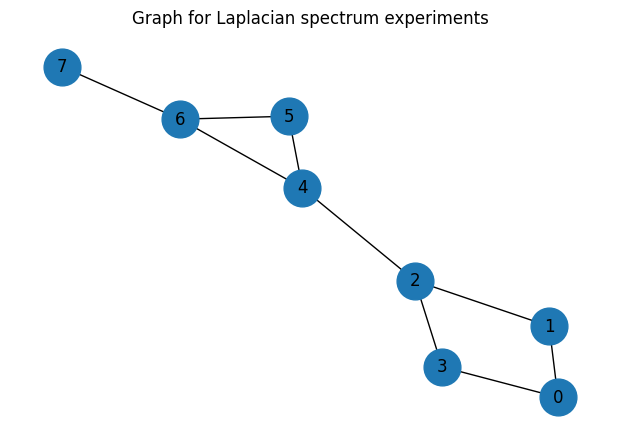

In [ ]:
plt.figure(figsize=(6,4))
pos = nx.spring_layout(G, seed=2)
nx.draw(G, pos, with_labels=True, node_size=700)
plt.title("Graph for Laplacian spectrum experiments")
plt.show()


## A2) Eigenvalues of the Laplacian and connected components

### Task A2
1. Compute eigenvalues of \(L\) and sort them.
2. Count how many are “zero” (tolerance 1e-8).
3. Compare with `nx.number_connected_components(G)`.

如果只有 1 个 0 ⇒ 图是连通的（只有 1 个连通分量.  
如果有 k 个 0 ⇒ 图被分成 k 坨互相不连通的部分（k 个连通分量.  
第一个 -0.：就是 0.  
第二个 0.278585：这就是lambda 2，叫 Fiedler eigenvalue(代数连通度).  
它 > 0 ⇒ 图连通. 
它越小 ⇒ 图越“容易被切开”（存在瓶颈/桥. 


In [11]:
eigvals, eigvecs = np.linalg.eigh(L)
eigvals_sorted = np.sort(eigvals)

tol = 1e-8
num_zero = int(np.sum(np.abs(eigvals_sorted) < tol))

print("Eigenvalues of L (sorted):")
print(np.round(eigvals_sorted, 6))
print("Number of ~zero eigenvalues:", num_zero)
print("Connected components (NetworkX):", nx.number_connected_components(G))


Eigenvalues of L (sorted):
[-0.        0.278585  1.111617  2.        2.315355  3.466437  4.
  4.828006]
Number of ~zero eigenvalues: 1
Connected components (NetworkX): 1


### Task A2B: Make the graph disconnected

Remove one edge to split the graph, then recompute.
Try removing edge `(2,4)` or `(6,7)` and see what changes.


Connected components (G2): 2
Eigenvalues (G2) sorted:
[-0.  0.  1.  2.  2.  3.  4.  4.]
Number of ~zero eigenvalues: 2


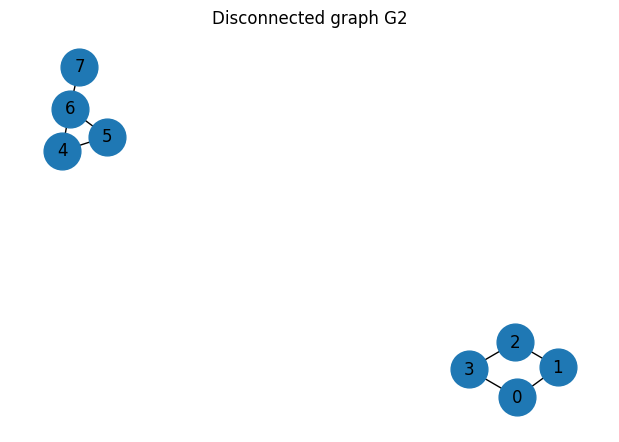

In [12]:
G2 = G.copy()
G2.remove_edge(2, 4)  # TODO: try (6,7) too

A2 = nx.to_numpy_array(G2, nodelist=sorted(G2.nodes()), dtype=float)
D2 = np.diag(A2.sum(axis=1))
L2 = D2 - A2

eigvals2, eigvecs2 = np.linalg.eigh(L2)
eigvals2_sorted = np.sort(eigvals2)

num_zero2 = int(np.sum(np.abs(eigvals2_sorted) < tol))

print("Connected components (G2):", nx.number_connected_components(G2))
print("Eigenvalues (G2) sorted:")
print(np.round(eigvals2_sorted, 6))
print("Number of ~zero eigenvalues:", num_zero2)

plt.figure(figsize=(6,4))
pos2 = nx.spring_layout(G2, seed=2)
nx.draw(G2, pos2, with_labels=True, node_size=700)
plt.title("Disconnected graph G2")
plt.show()


## A3) Fiedler value and Fiedler vector

For a connected graph:
- smallest eigenvalue \(\lambda_1 = 0\)
- second smallest eigenvalue \(\lambda_2\) = **Fiedler value**
- eigenvector for \(\lambda_2\) = **Fiedler vector**

We will colour nodes by Fiedler vector values and do a simple 2-way split.


Fiedler value lambda2 = 0.2785847967631886


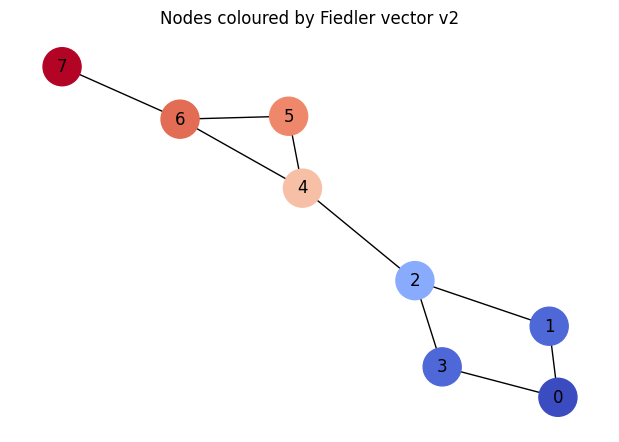

In [ ]:
# 算Fiedler value lambda2和Fiedler vector v2，并按数值上色
nodelist = sorted(G.nodes())  #固定节点顺序
A = nx.to_numpy_array(G, nodelist=nodelist, dtype=float)
D = np.diag(A.sum(axis=1))
L = D - A  #算出ADL（三个都是矩阵）

eigvals, eigvecs = np.linalg.eigh(L)  #求L的特征分解

lambda2 = eigvals[1] #取第二小的特征值和对应向量
v2 = eigvecs[:, 1]

print("Fiedler value lambda2 =", float(lambda2))

plt.figure(figsize=(6,4))
pos = nx.spring_layout(G, seed=2)
# 给 v2节点上色
nx.draw(G, pos, with_labels=True, node_size=750, node_color=v2, cmap=plt.cm.coolwarm)
plt.title("Nodes coloured by Fiedler vector v2")
plt.show()


Group v2 >= 0: [4, 5, 6, 7]
Group v2 <  0: [0, 1, 2, 3]


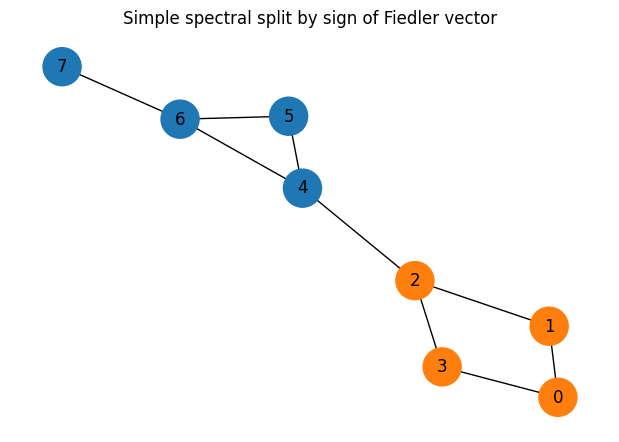

In [15]:
group_pos = [nodelist[i] for i, val in enumerate(v2) if val >= 0]
group_neg = [nodelist[i] for i, val in enumerate(v2) if val < 0]

print("Group v2 >= 0:", group_pos)
print("Group v2 <  0:", group_neg)

plt.figure(figsize=(6,4))
pos = nx.spring_layout(G, seed=2)
colors = ["tab:blue" if n in group_pos else "tab:orange" for n in nodelist]
nx.draw(G, pos, with_labels=True, node_size=750, node_color=colors)
plt.title("Simple spectral split by sign of Fiedler vector")
plt.show()


### Short answers (Part A)

Write 2–4 sentences each.

1. What did the number of zero eigenvalues tell you about connected components?
2. What is the Fiedler value/vector, and what does it help us do?


**Your answers here:**

1.  For the graph Laplacian L, the number of (approximately) zero eigenvalues equals the number of connected components in the graph.（零特征值的个数等于图的连通分量个数。如果只有一个0 eigenvalue，图九是联通的。如果有k个0，图被分成k个互不连通的部分。
2.  Fiedler Value是指Laplacian L的第二小特征值lambda2，对应特征向量叫Fiedler vector。 Lambda2可以衡量图“连得牢不牢”（越小表示越容易被切开、可能有瓶颈/桥边）。v2能帮助我们把节点按正负号或大小做一个自然的二分/社区划分，这是谱划分（spectral clustering）的基础。


# Part B — Centrality

We will compute and compare:
- Degree centrality
- Closeness centrality
- Betweenness centrality
- Eigenvector centrality
- PageRank

Different centralities capture **different meanings** of “importance”.


## B1) Compare centralities on three classic graphs

Graphs:
1. **Star** (one hub)
2. **Path** (a line)
3. **Barbell** (two dense groups connected by a bridge)

Run the cell and compare which nodes are “most central” under each measure.



===  Star (n=10)  ===
Top-3 Degree: [(0, 1.0), (1, 0.1111111111111111), (2, 0.1111111111111111)]
Top-3 Closeness: [(0, 1.0), (1, 0.5294117647058824), (2, 0.5294117647058824)]
Top-3 Betweenness: [(0, 1.0), (1, 0.0), (2, 0.0)]
Top-3 Eigenvector: [(0, 0.7071074555358021), (1, 0.2357020356122166), (2, 0.2357020356122166)]


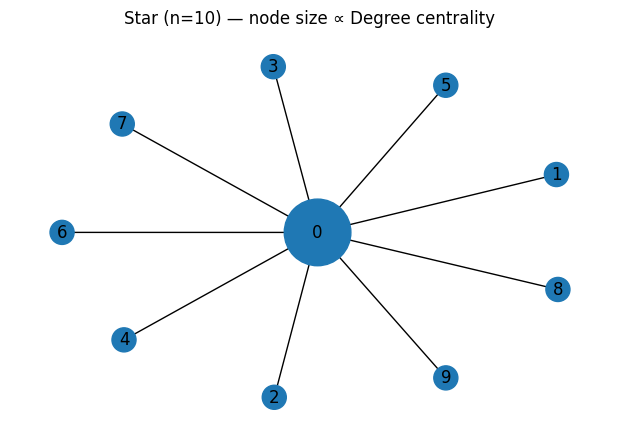

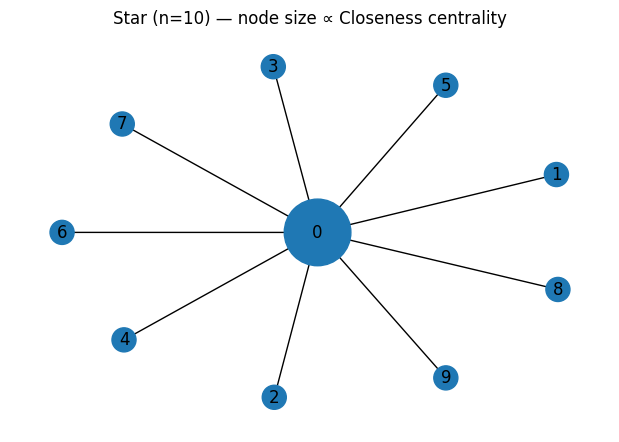

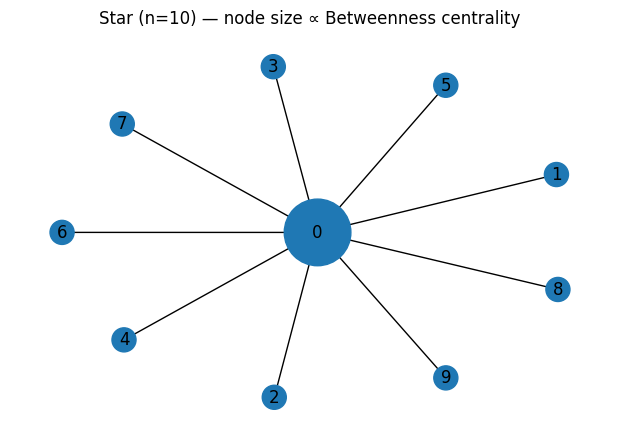


===  Path (n=10)  ===
Top-3 Degree: [(1, 0.2222222222222222), (2, 0.2222222222222222), (3, 0.2222222222222222)]
Top-3 Closeness: [(4, 0.36), (5, 0.36), (3, 0.3333333333333333)]
Top-3 Betweenness: [(4, 0.5555555555555556), (5, 0.5555555555555556), (3, 0.5)]
Top-3 Eigenvector: [(4, 0.422057177219455), (5, 0.42205717721945496), (3, 0.3878671150324336)]


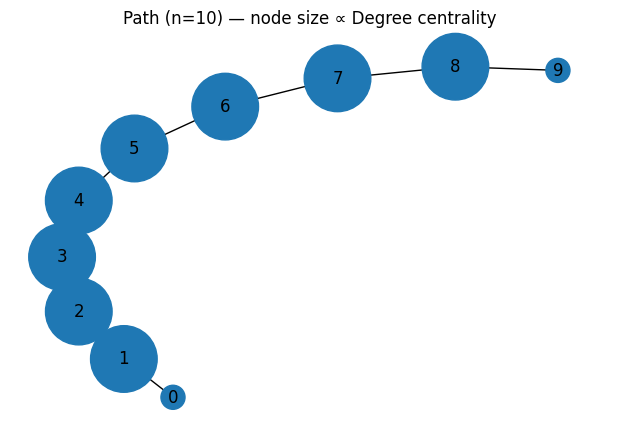

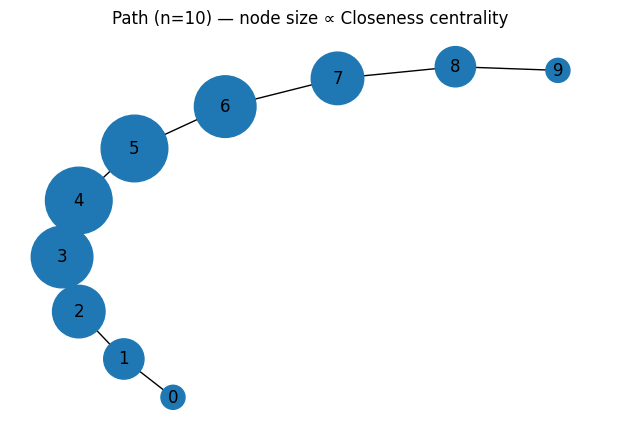

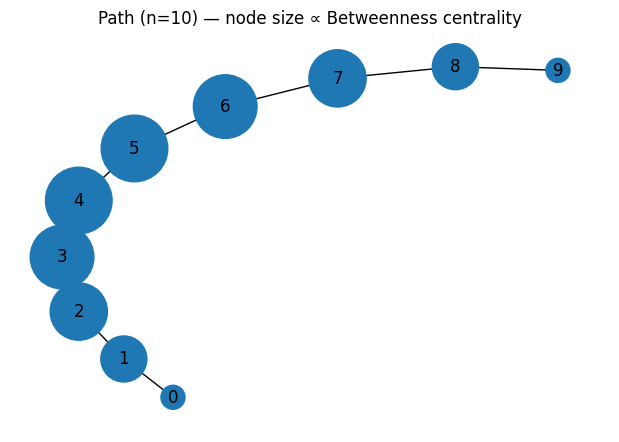


===  Barbell (m1=5,m2=1)  ===
Top-3 Degree: [(4, 0.5), (6, 0.5), (0, 0.4)]
Top-3 Closeness: [(5, 0.5555555555555556), (4, 0.5263157894736842), (6, 0.5263157894736842)]
Top-3 Betweenness: [(5, 0.5555555555555556), (4, 0.5333333333333333), (6, 0.5333333333333333)]
Top-3 Eigenvector: [(4, 0.33741721884366294), (6, 0.3374172188436629), (0, 0.30522128476445665)]


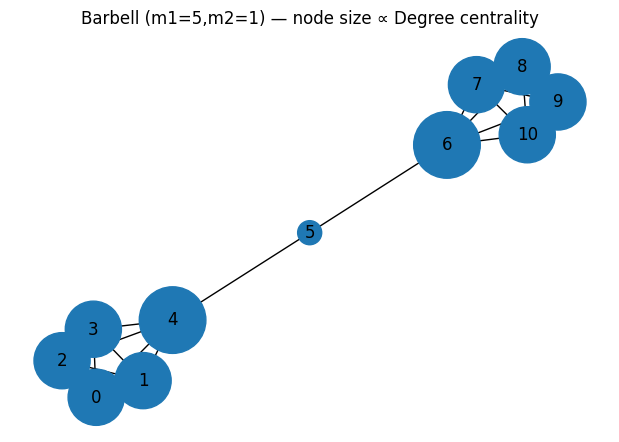

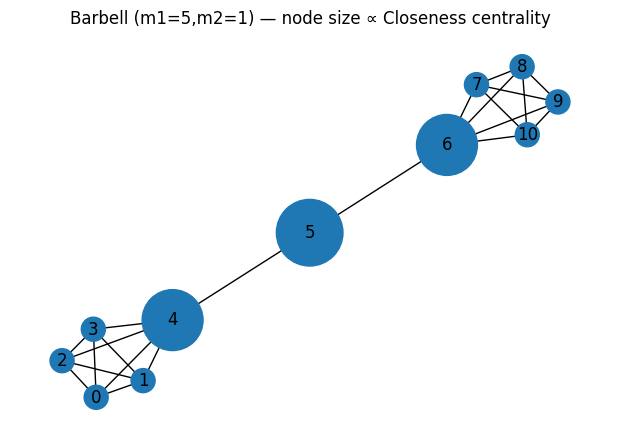

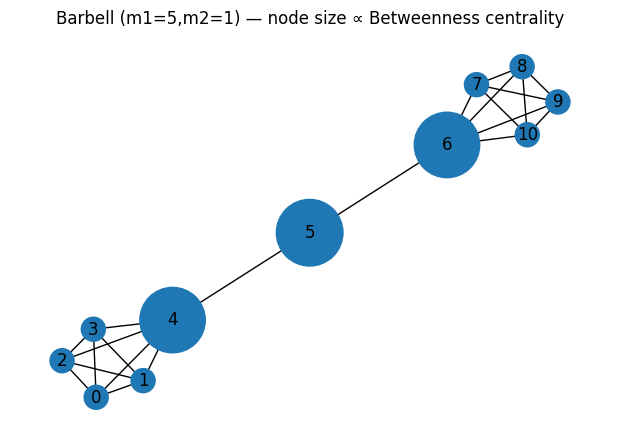

In [ ]:
def compute_centralities(H):
    deg = nx.degree_centrality(H) #degree中心性=你直接连了多少邻居（再除以n-1做归一化）
    clo = nx.closeness_centrality(H) #接近中心性=到所有点的最短路距离之和越小越中心（“离大家都近”）
    bet = nx.betweenness_centrality(H, normalized=True) #介数中心性=有多少最短路要经过你（“桥梁”）
    try:
        eig = nx.eigenvector_centrality(H, max_iter=1000) #特征向量中心性=我中心，因为我连着的也中心
    except Exception as e:
        eig = None
        print("Eigenvector centrality did not converge:", e)
    return deg, clo, bet, eig

def draw_with_node_size(H, scores, title):
    vals = np.array([scores[n] for n in H.nodes()])
    sizes = 300 + 2000 * (vals - vals.min()) / (vals.max() - vals.min() + 1e-12)
    plt.figure(figsize=(6,4))
    pos = nx.spring_layout(H, seed=2)
    nx.draw(H, pos, with_labels=True, node_size=sizes)
    plt.title(title)
    plt.show()

def top_k(scores, k=3):
    return sorted(scores.items(), key=lambda x: x[1], reverse=True)[:k]

graphs = {
    "Star (n=10)": nx.star_graph(9),
    "Path (n=10)": nx.path_graph(10),
    "Barbell (m1=5,m2=1)": nx.barbell_graph(5, 1)
}

for name, H in graphs.items():
    print("\n=== ", name, " ===")
    deg, clo, bet, eig = compute_centralities(H)

    print("Top-3 Degree:", top_k(deg))
    print("Top-3 Closeness:", top_k(clo))
    print("Top-3 Betweenness:", top_k(bet))
    if eig is not None:
        print("Top-3 Eigenvector:", top_k(eig))

    draw_with_node_size(H, deg, f"{name} — node size ∝ Degree centrality")
    draw_with_node_size(H, clo, f"{name} — node size ∝ Closeness centrality")
    draw_with_node_size(H, bet, f"{name} — node size ∝ Betweenness centrality")


## B2) Explain differences (short writing)

Write 2–4 sentences each.

1. In the **star graph**, why is the centre node high for degree, closeness, and betweenness?
2. In the **barbell graph**, which nodes have the highest betweenness? Why?
3. What does eigenvector centrality try to capture (in one sentence)?


**Your answers here:**

1.  
2.  
3.  


## B3) PageRank (random surfer)

Compute PageRank for two different `alpha` values (0.85 and 0.50) and compare rankings.


In [ ]:
DG = nx.DiGraph()
DG.add_edges_from([
    ("A", "B"),
    ("A", "C"),
    ("B", "C"),
    ("C", "A"),
    ("C", "D"),
    ("D", "C"),
    ("D", "E"),
    ("E", "D"),
])

plt.figure(figsize=(6,4))
pos = nx.spring_layout(DG, seed=3)
nx.draw(DG, pos, with_labels=True, node_size=700, arrows=True, arrowstyle="->", arrowsize=15)
plt.title("Toy directed graph for PageRank")
plt.show()

for alpha in [0.85, 0.50]:
    pr = nx.pagerank(DG, alpha=alpha)
    ranked = sorted(pr.items(), key=lambda x: x[1], reverse=True)
    print(f"\nalpha={alpha}")
    for node, score in ranked:
        print(f"  {node}: {score:.4f}")


### Task B3B (short answer)

1. Conceptually, what does changing `alpha` do?
2. Did the ranking change between alpha = 0.85 and 0.50? Why might it?


**Your answers here:**

1.  
2.  


## B4) Wrap-up reflection

Answer briefly:

1. One situation where **betweenness** is more useful than **degree**.
2. One situation where **PageRank** makes more sense than **eigenvector centrality**.
3. One-sentence main message of this lab.


**Your answers here:**

1.  
2.  
3.  


---
## Troubleshooting

- Eigenvector centrality may fail to converge: increase `max_iter` or treat it as optional.
- Tiny negative eigenvalues (e.g. -1e-12) are numerical rounding; treat as 0.
- If plots do not appear in VS Code, try running in browser Jupyter Notebook.
